# amaliemulator
notebook for getting Amalie started with training neural nets on her grid of stellar models. Likely to be a mess of pasted and pseudo code (sorry Amalie!)

In [55]:
#### misc
import pandas as pd
import numpy as np
import os
from pathlib import Path
import pickle
import time
from itertools import product

#### graphical
import matplotlib.pyplot as plt
import corner

#### ML
import sklearn
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
from keras import layers

##### poke gpu
os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

print("Current GPU usage:\n"
     + " - GPU0: " + str(gpu0usage) + "B\n")

Current GPU usage:
 - GPU0: 316475136B



## data prep
usually called 'data augmentation' in the ML community, but I think referees will have questions if you say "we augmented the data to make our network train better" - this is where we get our data ready for a neural network to start training.\
usually consists of:
- check and clean data to remove NaNs etc
- define our inputs and outputs for training
- scale data for better network training
- split into our *train*, *validation*, and *test* sets

### inps, outs and normalise

In [43]:
df_full = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/barbie_nu.h5', key='df') ## edit for your grid!!

#### define inputs
inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']

#### define outputs
classical_outputs = ['radius', 'luminosity', 'surface_Z']
astero_outputs = [f'nu_0_{i+1}' for i in range(15,25)] # 10 modes for now

outputs = classical_outputs+astero_outputs

df = df_full[inputs+outputs]

df_norm = (df - df.min())/(df.max() - df.min())

## check df_norm.describe looks reasonable (min=0, max=1):
df_norm.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,surface_Z,nu_0_16,nu_0_17,nu_0_18,nu_0_19,nu_0_20,nu_0_21,nu_0_22,nu_0_23,nu_0_24,nu_0_25
count,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06,1.160882e+06
mean,6.368254e-01,2.946521e-01,4.784779e-01,5.010575e-01,3.297499e-01,3.507220e-01,1.021305e-01,2.687424e-01,3.811411e-01,3.809857e-01,3.811407e-01,3.813563e-01,3.816525e-01,3.819317e-01,3.821951e-01,3.824622e-01,3.827019e-01,3.829539e-01
std,2.377429e-01,2.666994e-01,2.869593e-01,2.884864e-01,2.497901e-01,1.698813e-01,8.955022e-02,2.483849e-01,1.693456e-01,1.692041e-01,1.690380e-01,1.688894e-01,1.687943e-01,1.687081e-01,1.686277e-01,1.685631e-01,1.685077e-01,1.684881e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.660000e-01,6.466661e-02,2.287215e-01,2.515570e-01,1.272709e-01,2.308146e-01,3.860117e-02,5.064833e-02,2.581992e-01,2.582190e-01,2.586089e-01,2.590295e-01,2.594966e-01,2.599090e-01,2.602957e-01,2.607057e-01,2.610569e-01,2.613862e-01
50%,6.700000e-01,2.100469e-01,4.667237e-01,5.003053e-01,2.730798e-01,3.216508e-01,7.600686e-02,1.953707e-01,3.768755e-01,3.767587e-01,3.769879e-01,3.773078e-01,3.776838e-01,3.780518e-01,3.784121e-01,3.787779e-01,3.791128e-01,3.794663e-01
75%,8.320000e-01,4.770009e-01,7.226768e-01,7.512517e-01,4.900688e-01,4.376292e-01,1.377703e-01,4.415408e-01,4.987978e-01,4.984398e-01,4.983696e-01,4.984007e-01,4.985765e-01,4.987463e-01,4.989045e-01,4.990806e-01,4.992358e-01,4.994514e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### split into train/validate/test

In [68]:
#### train/test split with seed 
seed = 42

df_train = df_norm.sample(frac=0.95, random_state=seed)
df_test = df_norm.drop(df_train.index)

df_train_inputs, df_val_inputs, df_train_outputs, df_val_outputs = sklearn.model_selection.train_test_split(df_train[inputs],df_train[outputs], test_size = 0.05, random_state=seed)

print("Training set: ", len(df_train_inputs))
print("Validation set: ", len(df_val_inputs))
print("Test set: ", len(df_test))

Training set:  1047696
Validation set:  55142
Test set:  58044


## training our network
here we'll use our *train* and *validation* sets to train our neural network and check for overfitting\
I'm using the tensorflow functional API here - while this is a little harder to understand than the sequential API, it's more versatile and will let us do fun things like branching the neural network architecture later on!\
I'll start with a super simple network just to check whether tensorflow is working as intended:

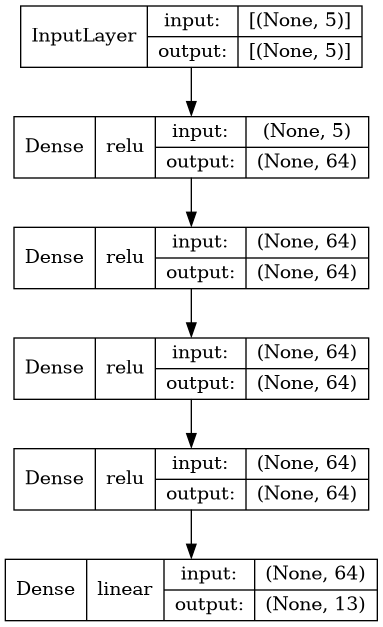

In [45]:
######## define architecture:
model_name = 'simple_network'
n_dense_layers = 4 #number of dense layers
dense_layer_units = 64 #neurons per dense layer

######## map out model architecture
#### input layer
nn_input = keras.Input(shape=(len(inputs),))

#### dense layer(s)
for n_dense_layer in range(n_dense_layers):
    if n_dense_layer == 0:
        dense_layer = layers.Dense(dense_layer_units, activation='relu')(nn_input)
    else:
        dense_layer = layers.Dense(dense_layer_units, activation='relu')(dense_layer)

#### output layer
nn_output =  layers.Dense(len(outputs), activation='linear')(dense_layer)

######## store architecture as keras model
model = keras.Model(inputs=nn_input, outputs=nn_output, name=model_name)

######## plot model
keras.utils.plot_model(model, "figs/"+model_name+".png", show_layer_activations=True, show_shapes=True, show_layer_names=False)

In [46]:
######## compile and start training

model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model.fit(df_train_inputs,
          df_train_outputs,
          validation_data=(df_val_inputs,df_val_outputs),
          batch_size=4096,
          verbose=1,
          epochs=10,
          shuffle=True) 

Epoch 1/10
256/256 [==============================] - 2s 3ms/step - loss: 0.0139 - val_loss: 4.7115e-04
Epoch 2/10
256/256 [==============================] - 1s 3ms/step - loss: 2.6469e-04 - val_loss: 1.6009e-04
Epoch 3/10
256/256 [==============================] - 1s 3ms/step - loss: 1.4775e-04 - val_loss: 1.1249e-04
Epoch 4/10
256/256 [==============================] - 1s 3ms/step - loss: 1.1060e-04 - val_loss: 9.5004e-05
Epoch 5/10
256/256 [==============================] - 1s 3ms/step - loss: 9.3917e-05 - val_loss: 7.8295e-05
Epoch 6/10
256/256 [==============================] - 1s 3ms/step - loss: 7.8390e-05 - val_loss: 6.2424e-05
Epoch 7/10
256/256 [==============================] - 1s 3ms/step - loss: 6.9144e-05 - val_loss: 6.7164e-05
Epoch 8/10
256/256 [==============================] - 1s 3ms/step - loss: 6.4942e-05 - val_loss: 7.6471e-05
Epoch 9/10
256/256 [==============================] - 1s 3ms/step - loss: 6.2158e-05 - val_loss: 4.7035e-05
Epoch 10/10
256/256 [===========

## testing the network
this section is very rushed, the main thing is to remember to rescale your data (as the network will predict in the normalised space), and to predict on the test set that was taken out of the dataset before training!

In [70]:
def unnorm(df_norm, df_min, df_max):
    df_unnorm = (df_norm*(df_max-df_min)) + df_min
    return df_unnorm

preds_norm = model(np.array(df_test[inputs]))

df_preds_norm = pd.DataFrame(preds, columns=outputs)
df_preds_unnorm = unnorm(preds_df_norm, df[outputs].min(), df[outputs].max())

df_test_unnorm = unnorm(df_test, df.min(), df.max())

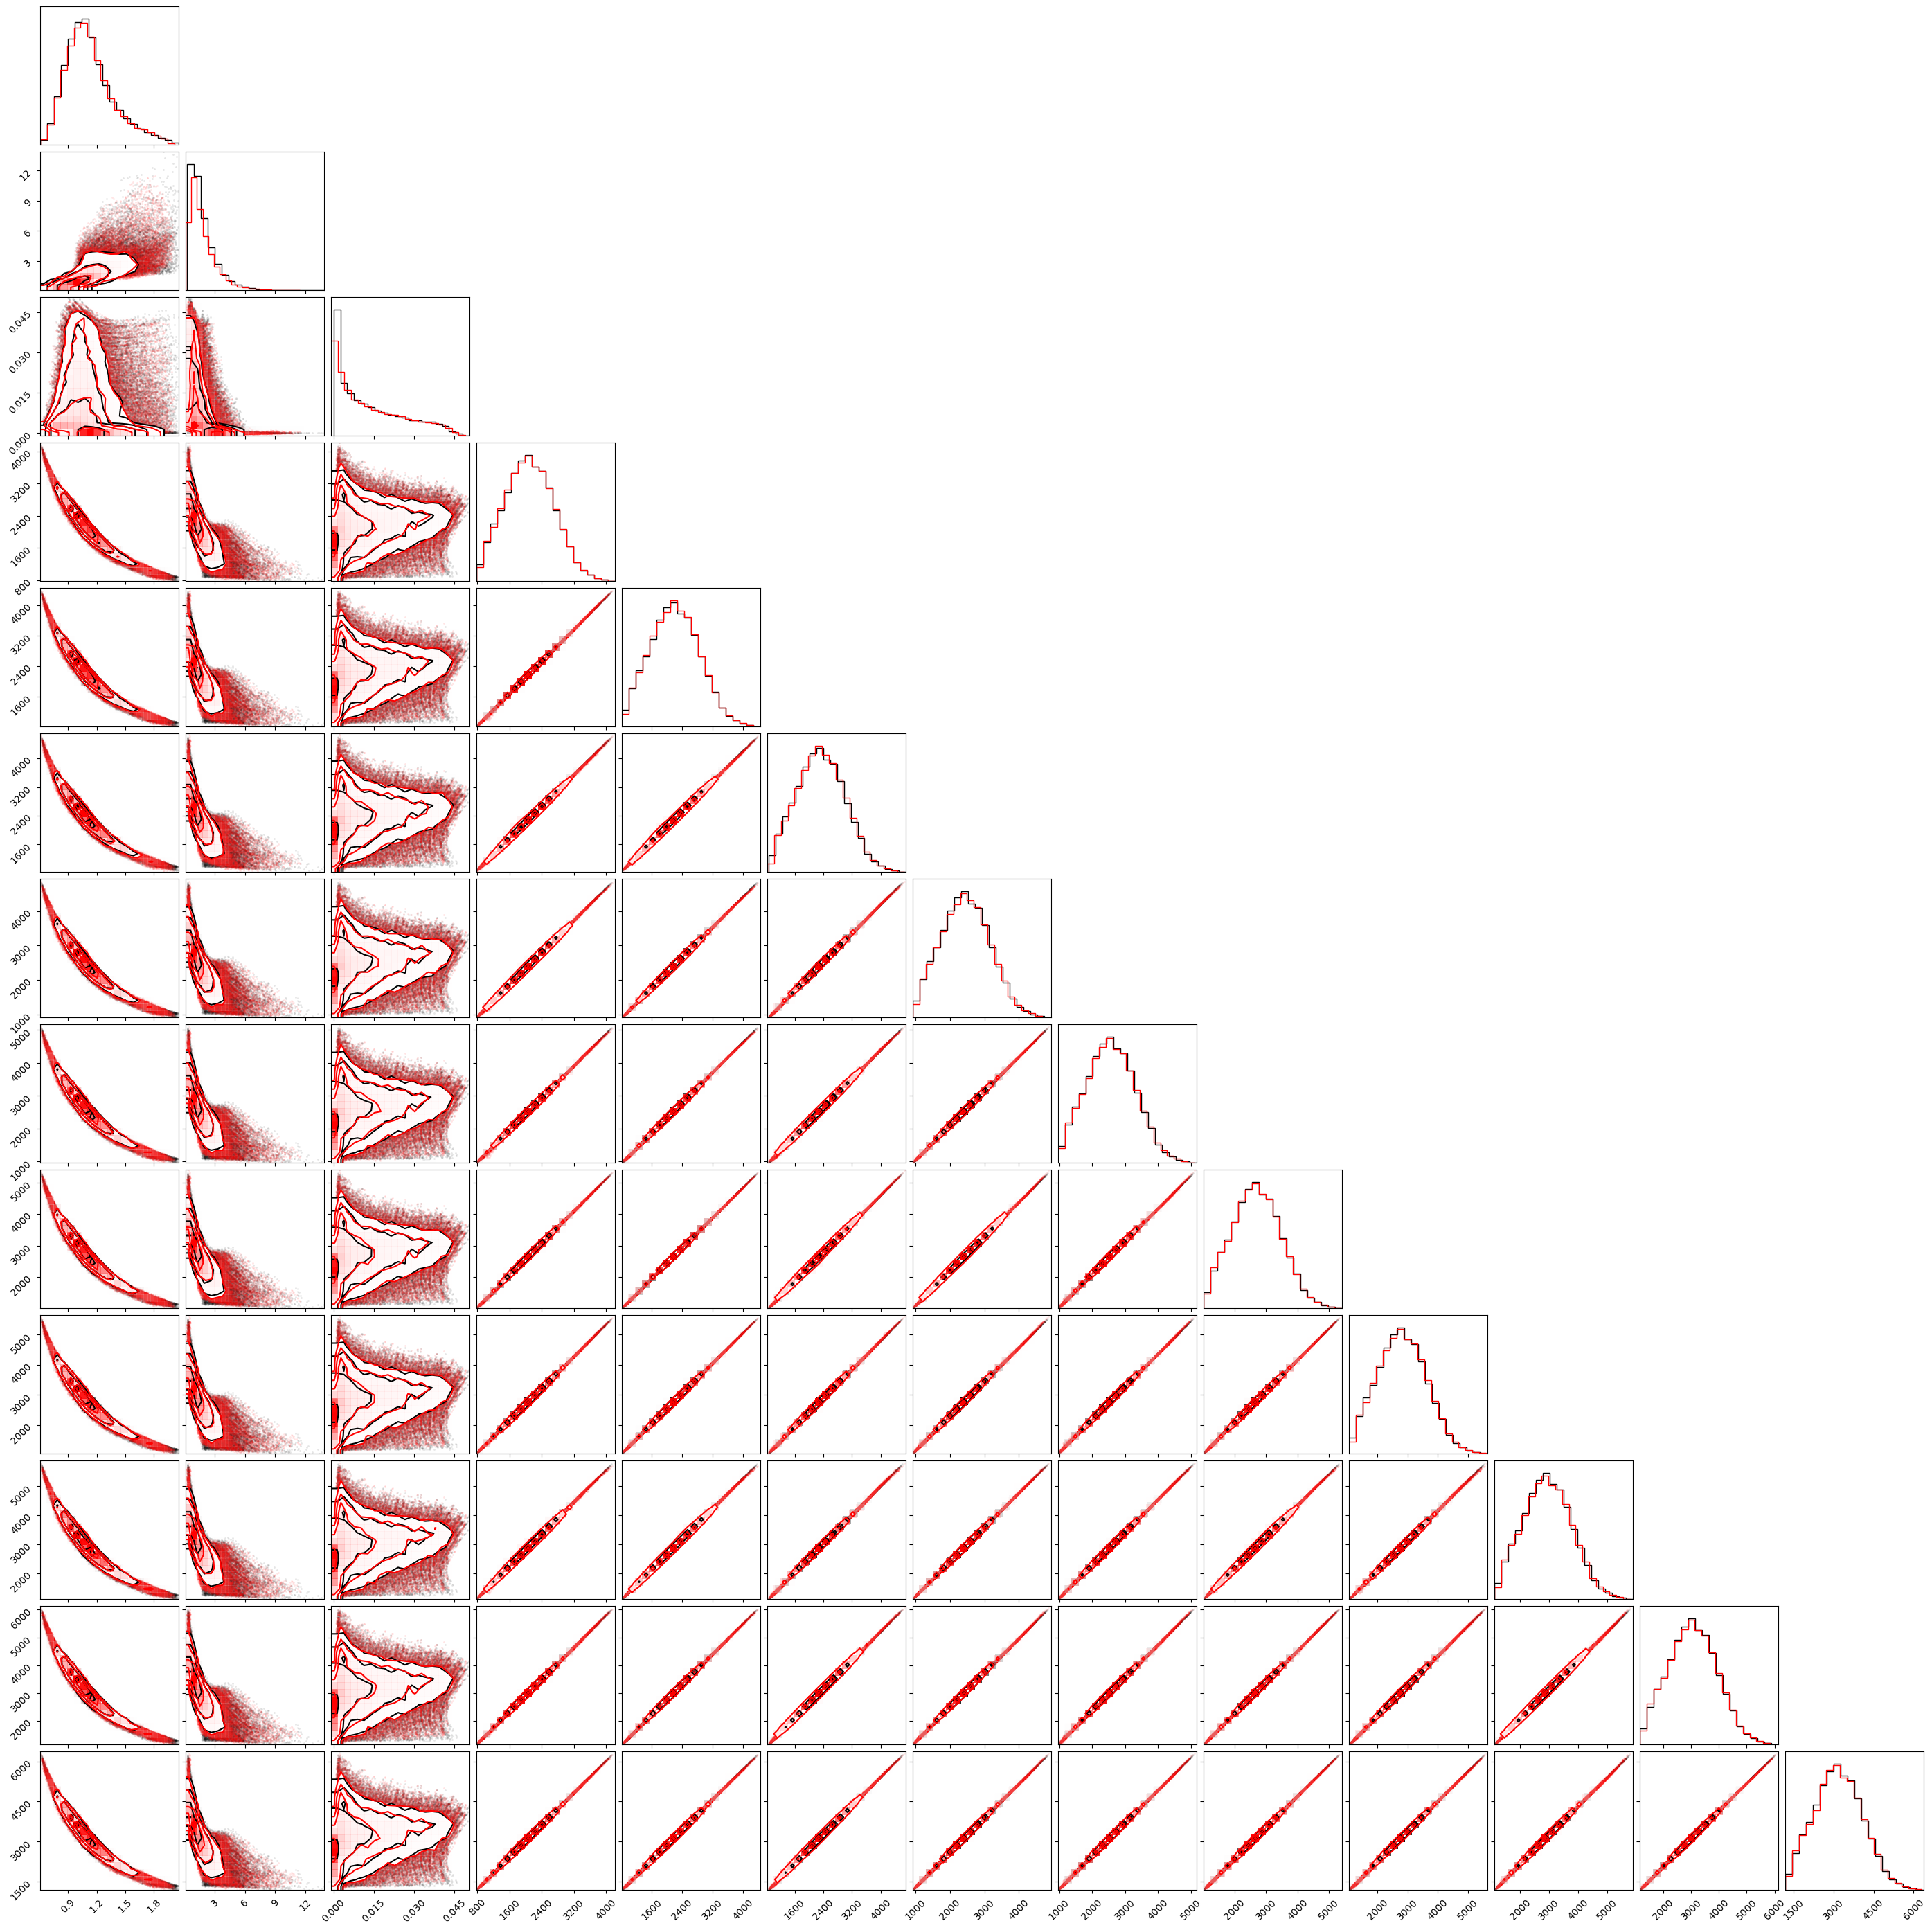

In [71]:
figure = corner.corner(df_test_unnorm[outputs])
corner.corner(df_preds_unnorm, color='red', fig=figure);